# HIERARCHICAL REGRESSION | SLEEPSTUDY EXAMPLE

## Load libraries

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
SEED = 7355608

## Load data

In [3]:
df = bmb.load_data('sleepstudy')
df.head()

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308


## Data ploting

In [4]:
def plot_data(data):
    fig, axes = plt.subplots(2, 9, figsize=(16, 7.5), sharey=True, sharex=True, dpi=300, constrained_layout=False)
    fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)

    axes_flat = axes.ravel()

    for i, subject in enumerate(data["Subject"].unique()):
        ax = axes_flat[i]
        idx = data.index[data["Subject"] == subject].tolist()
        days = data.loc[idx, "Days"].values
        reaction = data.loc[idx, "Reaction"].values

        # Plot observed data points
        ax.scatter(days, reaction, color="C0", ec="black", alpha=0.7)

        # Add a title
        ax.set_title(f"Subject: {subject}", fontsize=14)

    ax.xaxis.set_ticks([0, 2, 4, 6, 8])
    fig.text(0.5, 0.02, "Days", fontsize=14)
    fig.text(0.03, 0.5, "Reaction time (ms)", rotation=90, fontsize=14, va="center")

    return axes

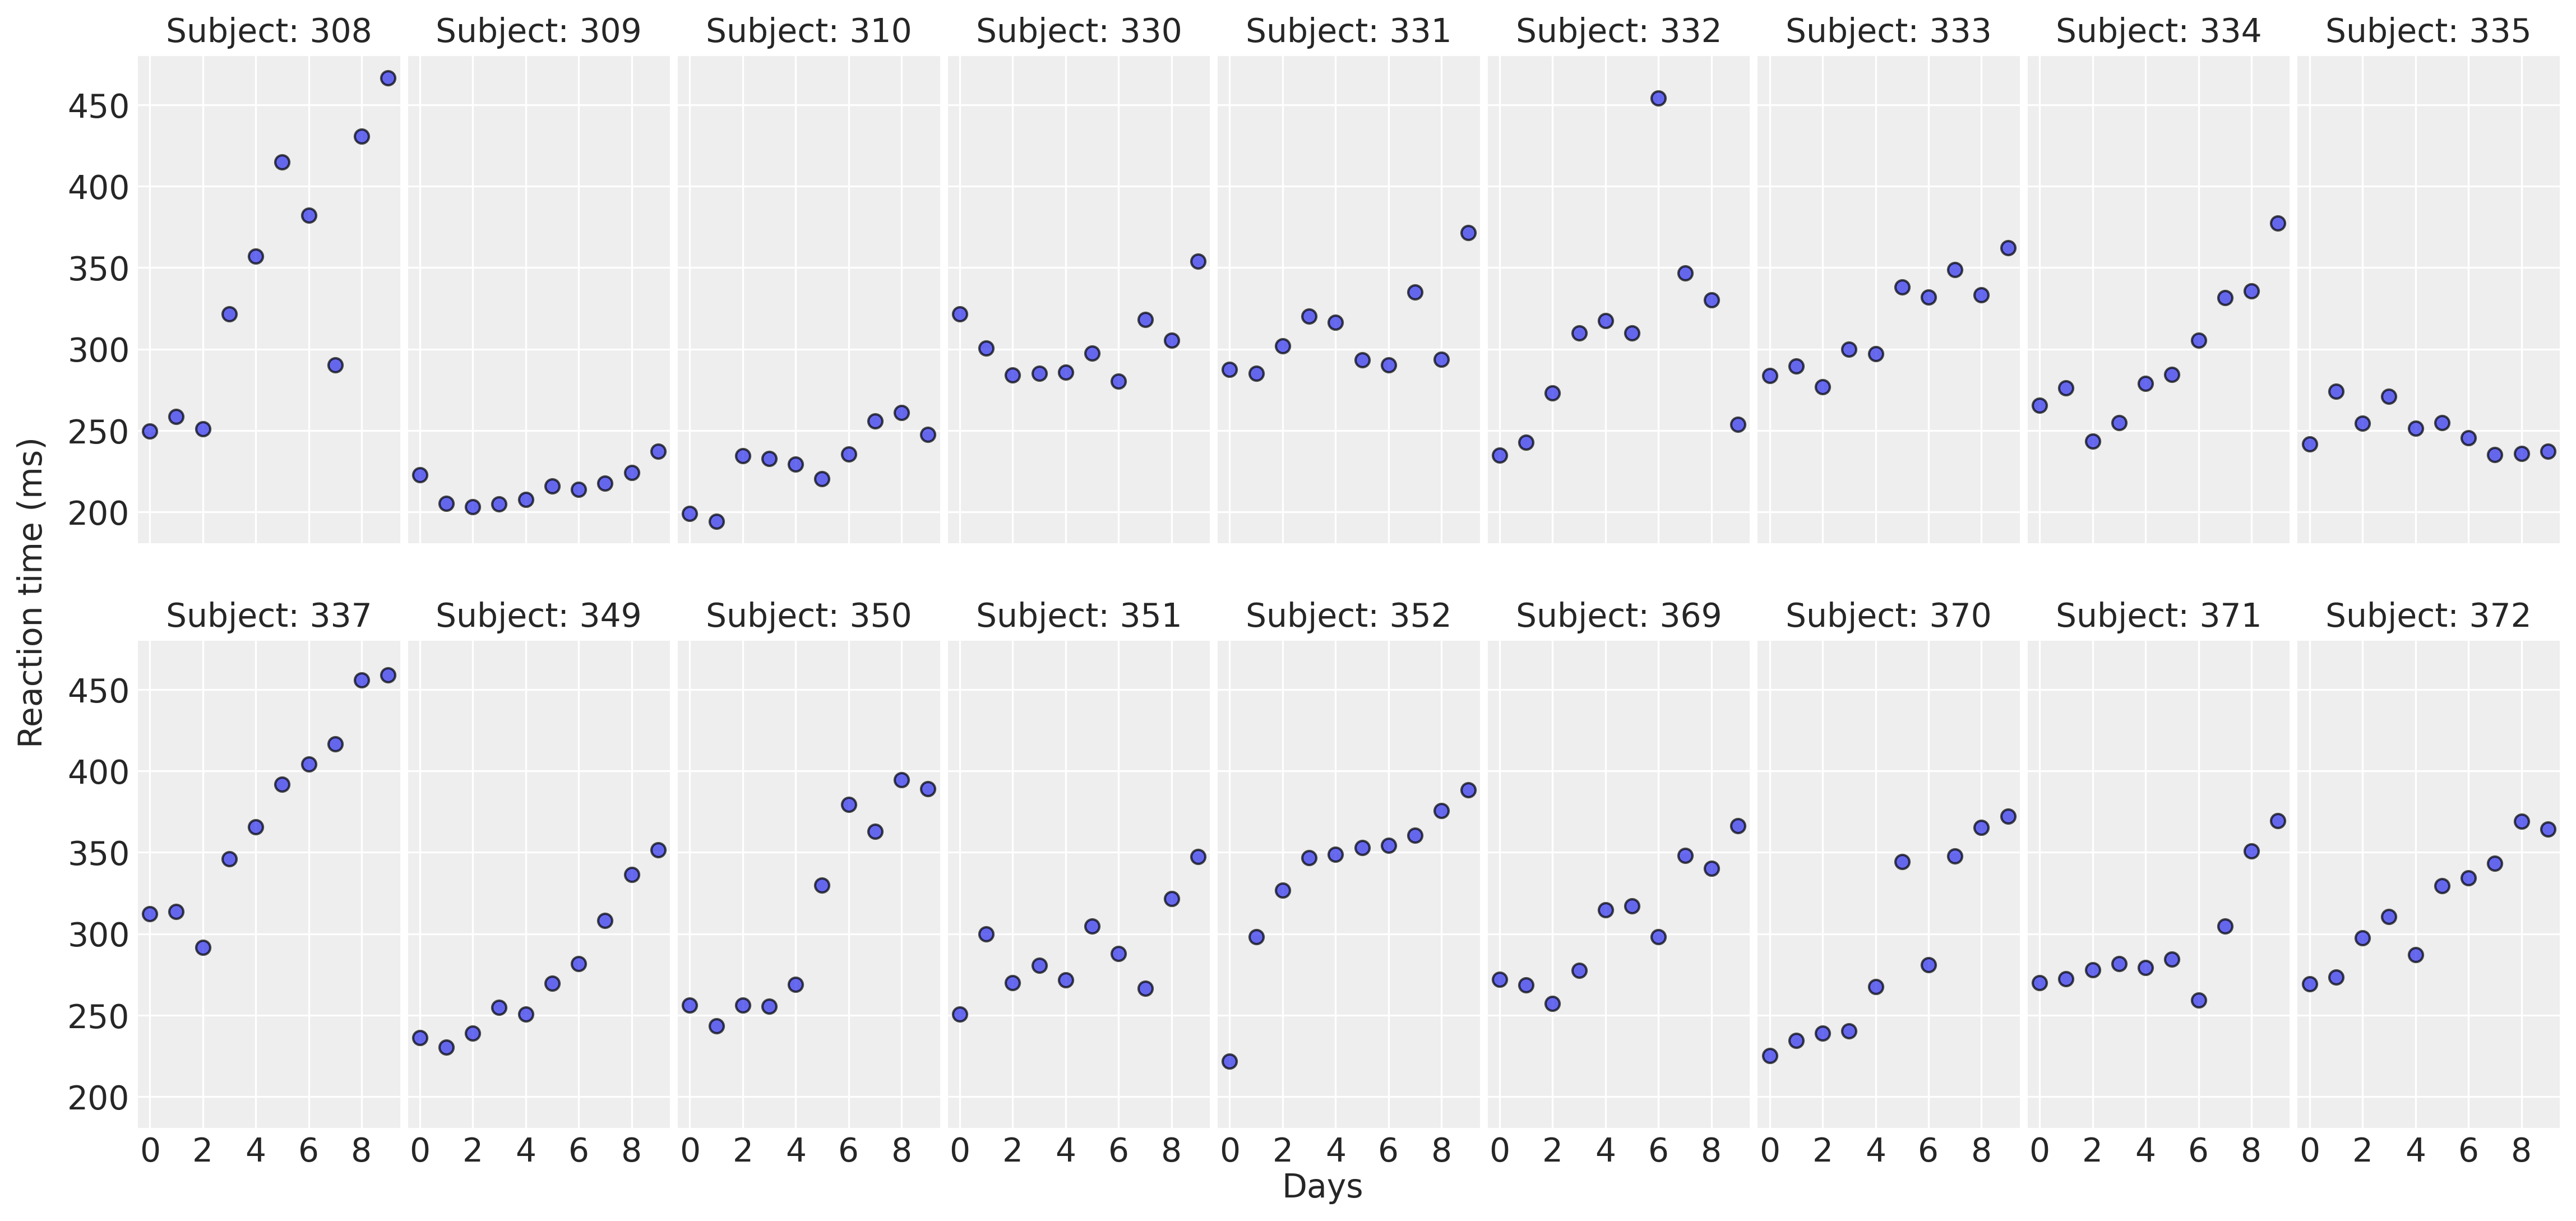

In [6]:
plot_data(df);

## Model fit

In [11]:
model = bmb.Model(
                    "Reaction ~ 1 + Days + (Days | Subject)",
                    df,
                    categorical = 'Subject',
)

In [12]:
model

       Formula: Reaction ~ 1 + Days + (Days | Subject)
        Family: gaussian
          Link: mu = identity
  Observations: 180
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 298.5079, sigma: 261.0092)
            Days ~ Normal(mu: 0.0, sigma: 48.8915)
        
        Group-level effects
            1|Subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 261.0092))
            Days|Subject ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 48.8915))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 56.1721)

In [13]:
idata = model.fit(draws = 2000, random_seed = SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Reaction_sigma, Intercept, Days, 1|Subject_sigma, 1|Subject_offset, Days|Subject_sigma, Days|Subject_offset]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.


## Model results

In [14]:
az.summary(
            idata,
            var_names = ['Intercept', 'Days'],
            kind = 'stats'
)

,mean,sd,hdi_3%,hdi_97%
Intercept,251.372,7.511,237.490,265.702
Days,10.469,1.728,7.243,13.664


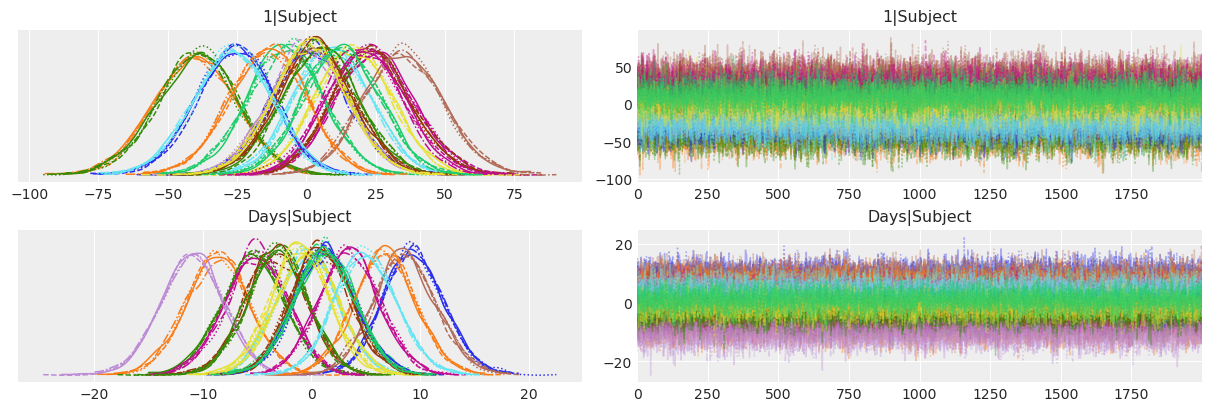

In [15]:
az.plot_trace(
                idata,
                var_names = ['1|Subject', 'Days|Subject']
);

In [16]:
post = az.extract(idata, num_samples = 500)

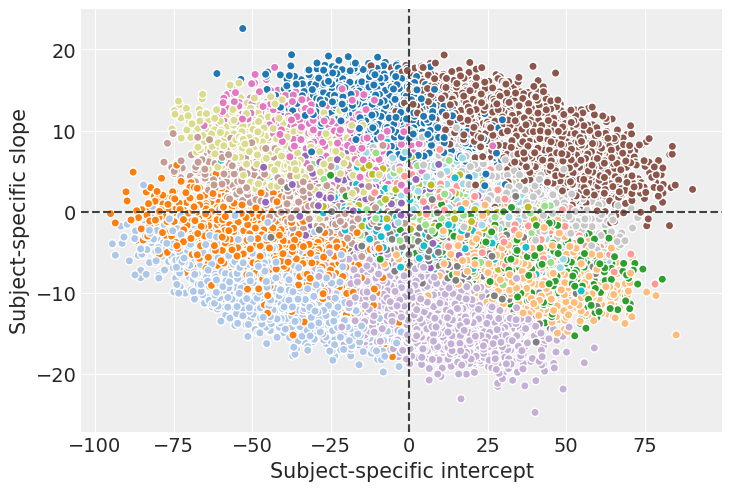

In [17]:
_, ax = plt.subplots()

idata.posterior.plot.scatter(
    x="1|Subject", y="Days|Subject",
    hue="Subject__factor_dim",
    add_colorbar=False,
    add_legend=False,
    cmap="tab20",
    edgecolors=None,
)                      

ax.axhline(c="0.25", ls="--")
ax.axvline(c="0.25", ls="--")
ax.set_xlabel("Subject-specific intercept")
ax.set_ylabel("Subject-specific slope");

In [18]:
# Obtain the posterior mean
model.predict(idata)

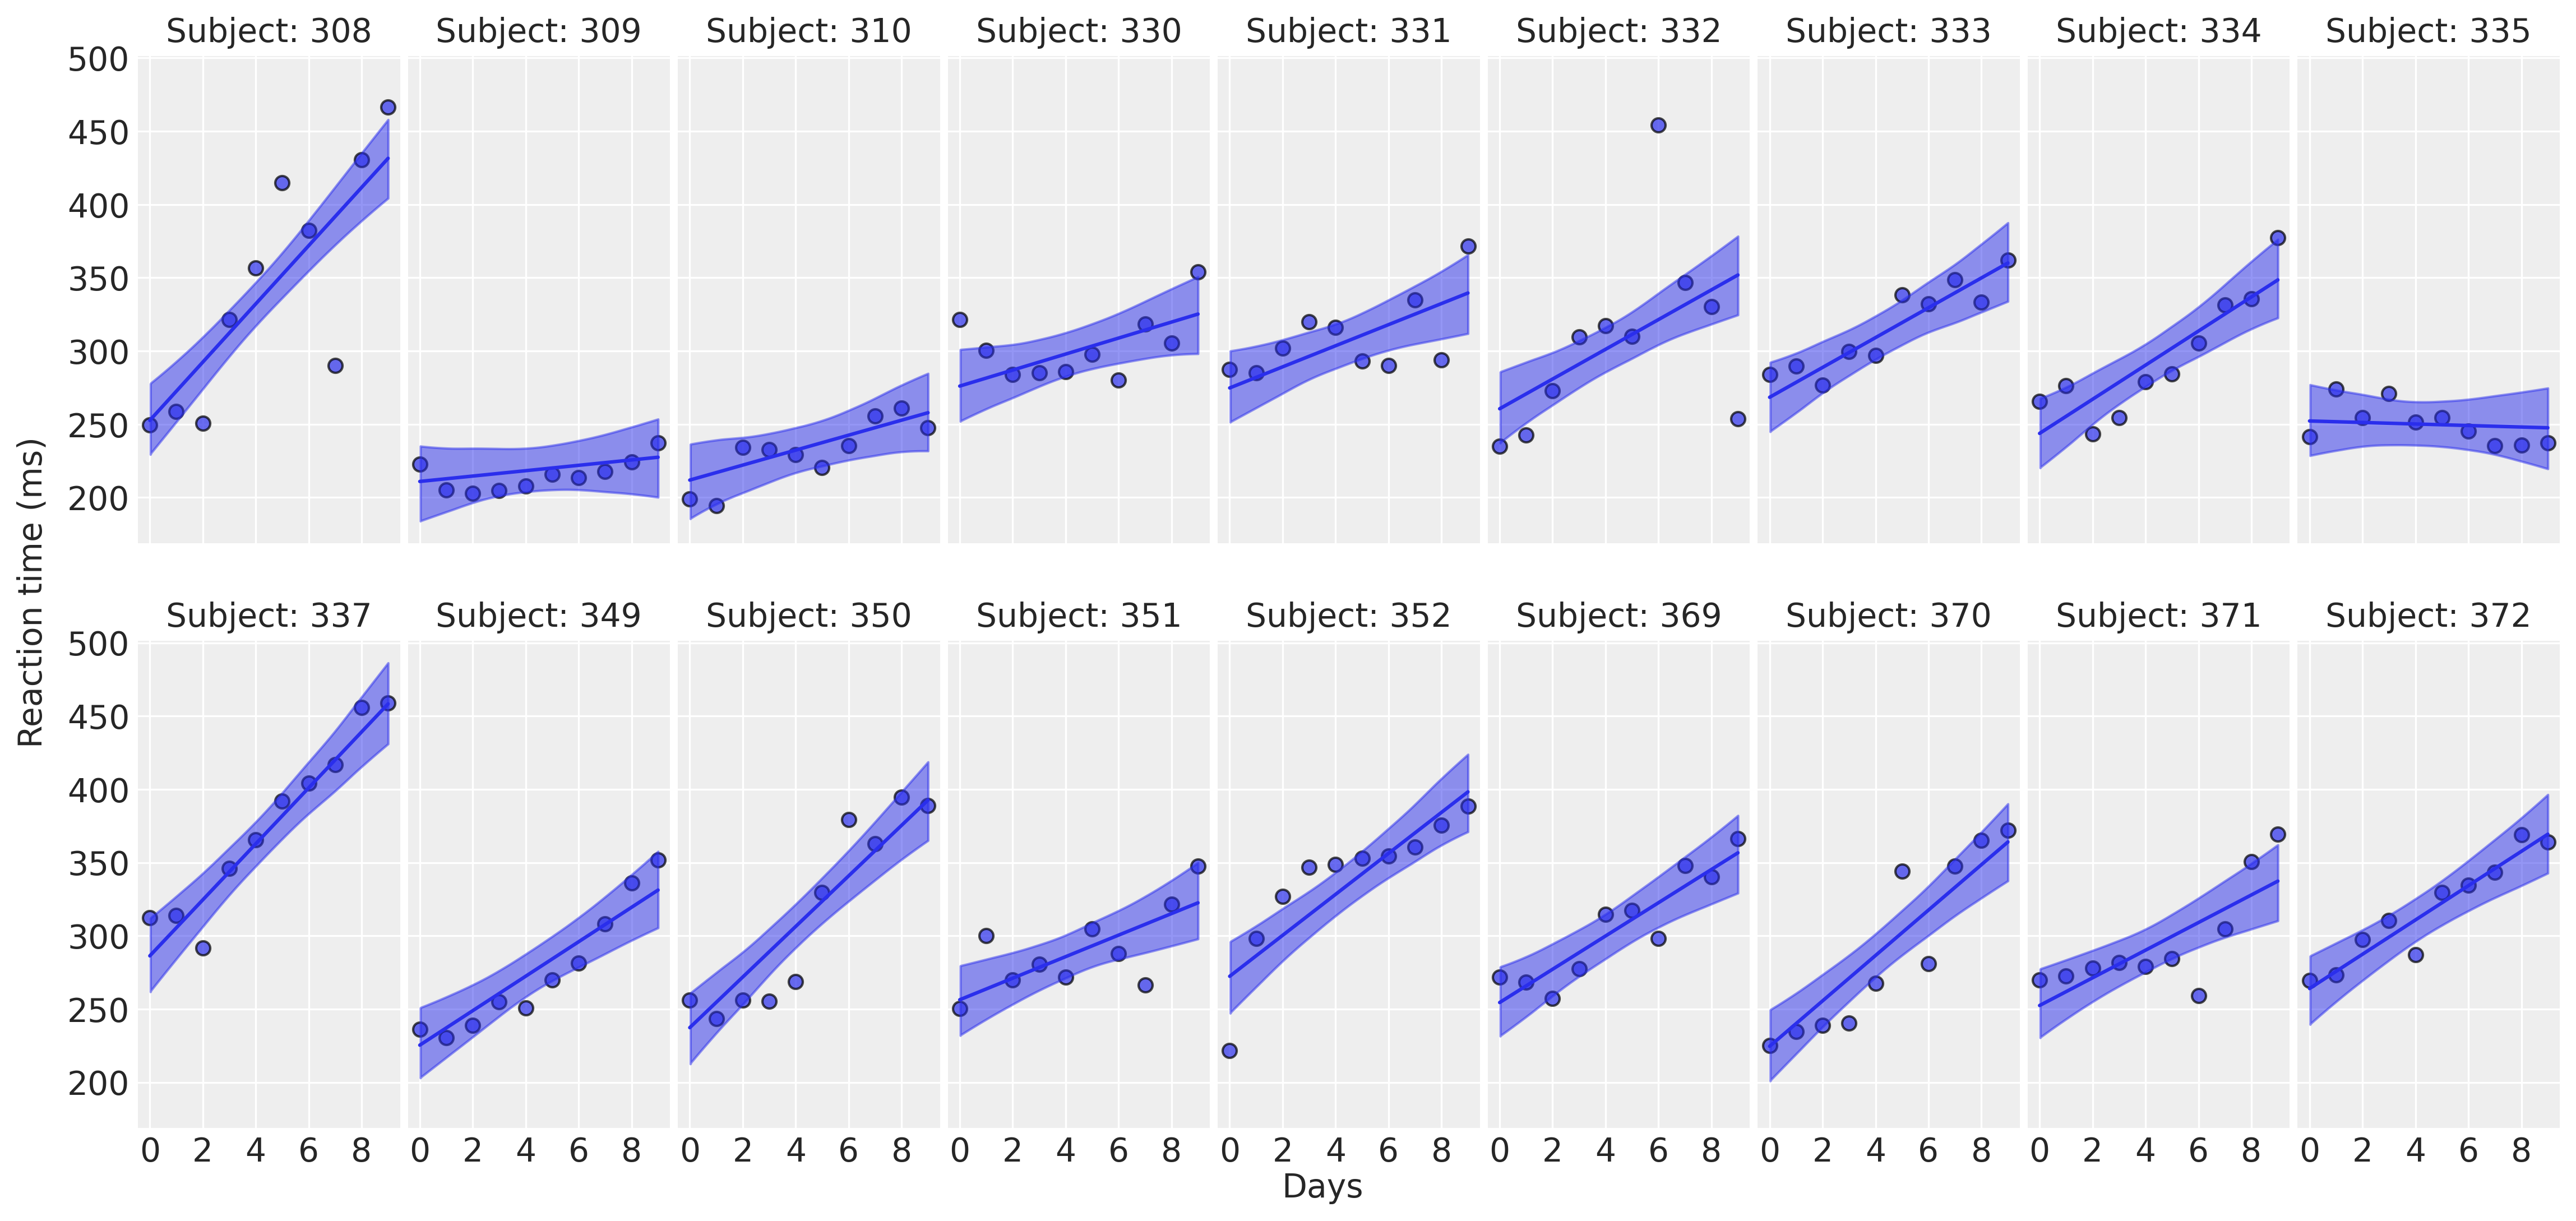

In [23]:
# Plot data
axes = plot_data(df)

# take the posterior of the mean reaction time
reaction_mean = az.extract(idata)['Reaction_mean'].values

for subject, ax in zip(df["Subject"].unique(), axes.ravel()):

    idx = df.index[df["Subject"]== subject].tolist()
    days = df.loc[idx, "Days"].values
    
    # Plot highest density interval / credibility interval
    az.plot_hdi(days, reaction_mean[idx].T[np.newaxis], color="C0", ax=ax)
    
    # Plot mean regression line
    ax.plot(days, reaction_mean[idx].mean(axis=1), color="C0")